# Задание 5.

Загрузите [данные по изменению температуры поверхности земли](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data). Для этого может понадобится зарегистрироваться на [Kaggle](https://kaggle.com). Затем нужно будет работать с данными, которые содержатся в файле **GlobalLandTemperaturesByMajorCity.csv**

**NB** Все подсчеты необходимо делать с помощью `PySpark`, без применения `pandas api`. Можно использоать `SQL`.

In [172]:
import os
import sys
import re

from pyspark.sql import functions as F
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType, FloatType
import seaborn as sns

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [173]:
import zipfile

import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

%matplotlib inline

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("PySpark") \
    .getOrCreate()

with open("GlobalLandTemperaturesByMajorCity.csv") as f:
    pandas_df = pd.read_csv(f)
    df = spark.createDataFrame(pandas_df)

df.show(10)

+----------+------------------+-----------------------------+-------+--------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|       Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+--------------+--------+---------+
|1849-01-01|            26.704|                        1.435|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1849-02-01|            27.434|                        1.362|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1849-03-01|            28.101|                        1.612|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1849-04-01|             26.14|           1.3869999999999998|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1849-05-01|            25.427|                          1.2|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1849-06-01|            24.844|                        1.402|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1849-07-01|24.058000000000003|                        1.254|Abi

# Задание 3.1 (1 балл) +

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [174]:
df = df.filter(F.year('dt')>=1950).dropna()
df.show(5)

get_lat = udf(lambda x: float(x[:-1]) if x[-1]=='N' else -float(x[:-1]),FloatType())
get_long = udf(lambda x: -float(x[:-1]) if x[-1]=='W' else float(x[:-1]),FloatType())
df = df.withColumn('new_Lat', get_lat(col('Latitude')))
df = df.withColumn('new_long', get_long(col('Longitude')))

+----------+------------------+-----------------------------+-------+--------------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty|   City|       Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-------+--------------+--------+---------+
|1950-01-01|26.773000000000003|                        0.239|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1950-02-01|            27.527|                        0.348|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1950-03-01|            28.344|                        0.431|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1950-04-01|             27.83|                        0.467|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
|1950-05-01|            26.896|                        0.248|Abidjan|CГґte D'Ivoire|   5.63N|    3.23W|
+----------+------------------+-----------------------------+-------+--------------+--------+---------+
only showing top 5 rows



# Задание 3.2 (2 балла) +

Постройте график среднегодовых температур в городе Торонто.

<AxesSubplot: xlabel='year', ylabel='Avg_temp'>

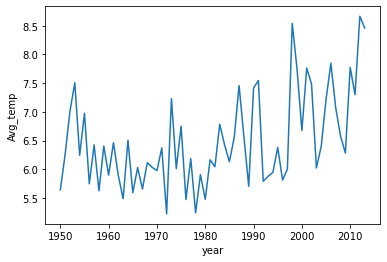

In [175]:
df_temp = df.filter(col('City')=='Toronto')
df_temp = df_temp.groupby(F.year('dt').alias('year'))\
    .avg()
df_temp=df_temp.sort(col('year'))

pandas_df = df_temp.withColumnRenamed('avg(AverageTemperature)','Avg_temp').toPandas()
sns.lineplot(data=pandas_df,x='year',y='Avg_temp')

# Задание 3.3 (2 балла) +

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна.

In [176]:
df_temp = df.groupby(col('City').alias('City'))\
    .agg(F.var_pop('AverageTemperature').alias('var'))
max = df_temp.agg({"var": "max"}).collect()[0][0]
df_temp.filter(col('var')==max).show()

+------+------------------+
|  City|               var|
+------+------------------+
|Harbin|218.61209943879504|
+------+------------------+



# Задание 3.4 (4 балла) +

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

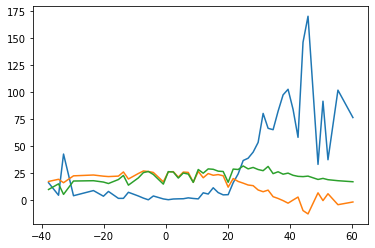

In [177]:
df_temp = df.groupby(col('new_Lat').alias('latitude'))\
    .agg(F.var_pop('AverageTemperature').alias('avg'))
pandas_df = df_temp.sort(col('latitude').alias('latitude')).toPandas()
plt.plot(pandas_df['latitude'],pandas_df['avg'])

df_temp = df.filter((F.year('dt')==1975)&(F.month('dt')==1))
df_temp = df_temp.groupby(col('new_Lat').alias('latitude'))\
    .agg(F.mean('AverageTemperature').alias('avg'))
pandas_df = df_temp.sort(col('latitude').alias('latitude')).toPandas()
plt.plot(pandas_df['latitude'],pandas_df['avg'])

df_temp = df.filter((F.year('dt')==1975)&(F.month('dt')==7))
df_temp = df_temp.groupby(col('new_Lat').alias('latitude'))\
    .agg(F.mean('AverageTemperature').alias('avg'))
pandas_df = df_temp.sort(col('latitude').alias('latitude')).toPandas()
plt.plot(pandas_df['latitude'],pandas_df['avg'])

# Задание 3.5 (6 баллов) +

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

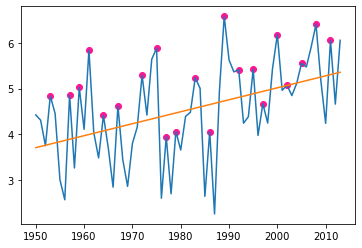

In [178]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pyspark.sql.window import Window

df_temp = df.filter(col('City')=='Saint Petersburg')\
    .groupby(F.year('dt').alias('year'))\
    .agg(F.mean('AverageTemperature').alias('mean'))\
    .sort('year')
pandas_df =df_temp.toPandas()
plt.plot(pandas_df['year'],pandas_df['mean'])

windowSpec  = Window.orderBy("year")
df_temp = df_temp.withColumn('left',df_temp.mean -F.lag('mean', -1)
                             .over(windowSpec))
df_temp = df_temp.withColumn('right',df_temp.mean -F.lag('mean', 1)
                             .over(windowSpec))
df_temp = df_temp.filter((col('left')>0)&(col('right')>0))
pandas_df1 = df_temp.toPandas()
plt.scatter(pandas_df1['year'],pandas_df1['mean'],c = 'deeppink')

lr=LinearRegression()
lr.fit(pandas_df.year.unique().reshape(-1,1),pandas_df['mean'])
plt.plot(pandas_df['year'],lr.predict(pandas_df.year.unique().reshape(-1,1)))

# Задание 3.6 (4 балла) +

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

In [179]:
def get_dif(df1,df2):
    df_all = df1.join(df2,df1.city1==df2.city,'inner')
    df_all = df_all.withColumn('diff', F.abs(col('max')-col('min')))
    max = df_all.agg({"diff": "max"}).collect()[0][0]
    df_all.filter(col('diff')==max).select('city').show()

df_temp = df.groupby([col('City').alias('City'),F.year('dt').alias('year')])\
    .agg(F.mean('AverageTemperature').alias("mean"))
df_min = df_temp.groupby(col('City').alias('city'))\
    .agg(F.min('mean').alias('min'))
df_max = df_temp.groupby(col('City').alias('city1'))\
    .agg(F.max('mean').alias('max'))
get_dif(df_max,df_min)

df_jan = df.filter((F.month('dt')==1)).groupby(col('City').alias('city1'))\
    .agg(F.mean('AverageTemperature').alias('max'))
df_jul = df.filter((F.month('dt')==7)).groupby(col('City').alias('city'))\
    .agg(F.mean('AverageTemperature').alias('min'))
get_dif(df_jan,df_jul)

df_temp = df.filter(col('AverageTemperature')<0)\
    .groupby([col('City').alias('city'),F.year('dt').alias('year')])\
    .agg(F.count('AverageTemperature').alias('count'))\
    .groupby(col('city').alias('City'))\
    .agg(F.mean('count').alias('mean'))
max = df_temp.agg({"mean": "max"}).collect()[0][0]
df_temp.filter(col('mean')==max)\
    .select('City').show()

+-------+
|   city|
+-------+
|Mashhad|
+-------+

+------+
|  city|
+------+
|Harbin|
+------+

+------+
|  City|
+------+
|Harbin|
+------+



# Задание 3.7 (3 балла) +

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 


**\***(+3 балла). Вычислите прямую с "трендом" по изменению средней температуры за год в каждом городе в период 1950-2013 (можно с помощью линейной регрессии, как в задании **3.5**). Отобразите города цветом, который зависит от угла наклона этой прямой. 


**\***(+1 балл) В дополнение к предыдущему пункту, используйте библиотеку [pwlf](https://pypi.org/project/pwlf/) с фиксированным числом сегментов и визуализируйте угол наклона последнего сегмента. 

Text(0.5, 1.0, 'Cites')

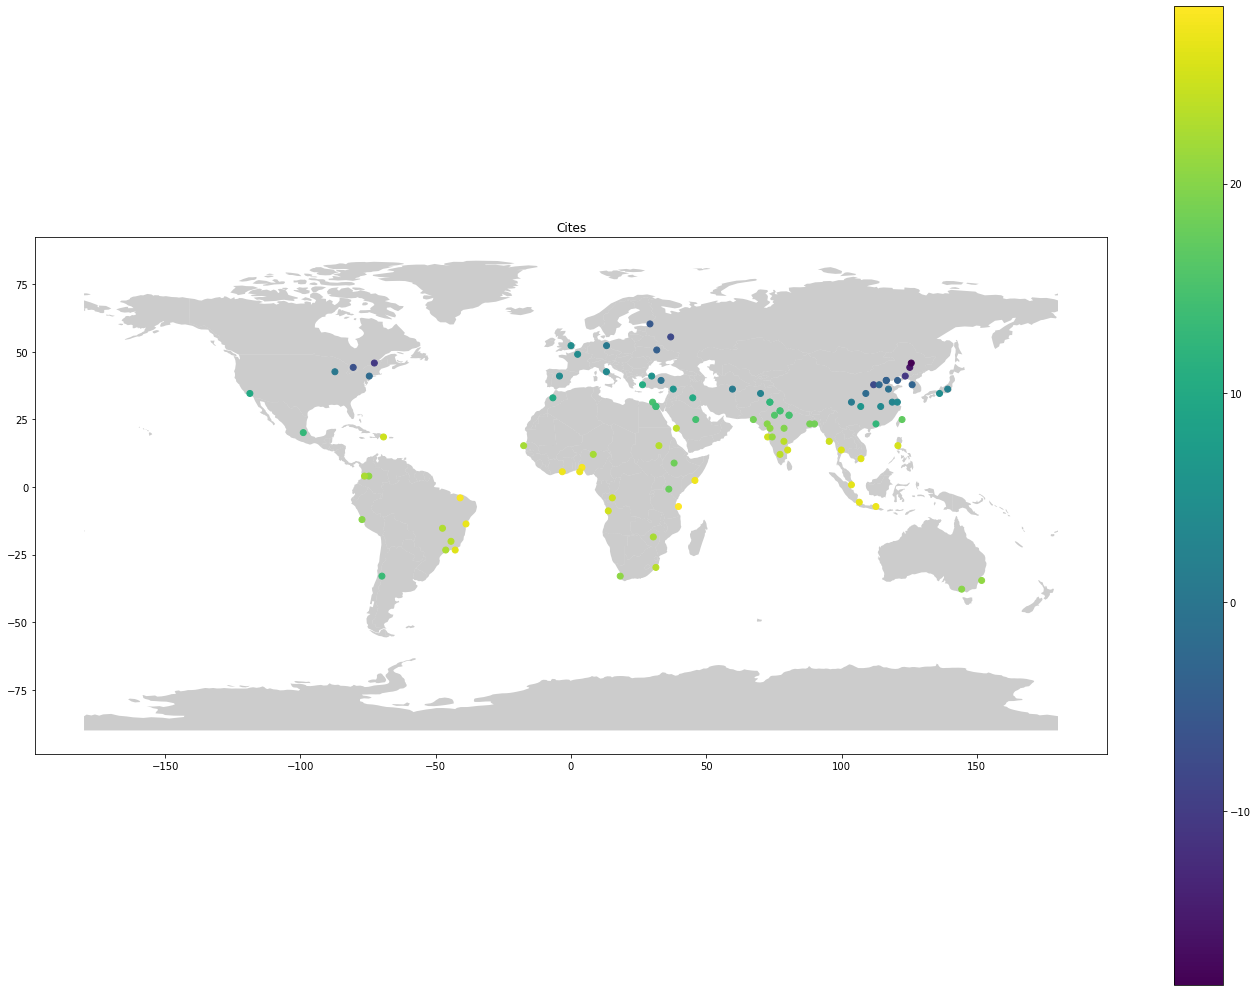

In [180]:
import geopandas
import folium

df_temp = df.filter((F.year('dt')>2003)&(F.month('dt')==1))\
    .groupby(col('City').alias('City'))\
    .agg(F.mean('AverageTemperature').alias('mean_temp'),
         F.mean('new_lat').alias('lat'),
         F.mean('new_long').alias('long'))\
    .sort(col('City'))

pandas_df = df_temp.toPandas()
geometry = geopandas.points_from_xy(pandas_df.long, pandas_df.lat)
geo_df = geopandas.GeoDataFrame(
    pandas_df[['mean_temp','City']], geometry=geometry
)
geo_df.head()
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(column="mean_temp", ax=ax, legend=True)
plt.title("Cites")

# *Задание 3.8 (8 баллов)

Цель - создать проект, который как минимум включает:
1. Использование юнит-тестов ([pytest](https://pytest.org)).
2. Применение средств форматирования и проверки исходного кода (например: [isort](https://pycqa.github.io/isort/), [black](https://black.readthedocs.io/en/stable/), [flake8](https://flake8.pycqa.org/en/latest/), [mypy](https://mypy.readthedocs.io/en/stable/)).
3. Спецификацию проекта в [pyproject.toml](https://pip.pypa.io/en/stable/reference/build-system/pyproject-toml/).
4. Использование утилит для работы с командной строкой ([argparse](https://docs.python.org/3/library/argparse.html), [click](https://click.palletsprojects.com/en/8.1.x/) и т.п.)
5. Сборку проекта в Wheel-файл.

Проект должен быть загружен в репозиторий. Функционал - произвольный, но должны использоваться данные из этого домашнего задания. Сам файл передается в качестве первого аргумента командной строки.  Например:

> python3 -m homeproject.app GlobalLandTemperaturesByMajorCity.csv 1980

Выдает самый жаркий месяц и город по наблюдениям за 1980 год.

*Ссылка на проект*